### Project Title: E-Commerce Customer Insights & Predictive Churn Analysis
### The Goal: Analyze customer transaction history to identify segments, predict which customers are likely to stop buying (churn), and provide actionable recommendations to the marketing team. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
df_1 = pd.read_excel("online_retail.xlsx", 
              sheet_name="Year 2009-2010")

In [4]:
df_2 = pd.read_excel("online_retail.xlsx",
                     sheet_name="Year 2010-2011")

In [5]:
df_1.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [6]:
df_2.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [7]:
full_df = pd.concat([df_1, df_2], ignore_index=True)

In [9]:
full_df.duplicated().sum()

np.int64(34335)

In [10]:
full_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [17]:
full_df['Invoice'] = full_df['Invoice'].astype(str)
full_df['StockCode'] = full_df['StockCode'].astype(str)
full_df['Description'] = full_df['Description'].astype(str)

In [18]:
# Save to Parquet
full_df.to_parquet('online_retail_full.parquet',
                   index=False)

In [2]:
df = pd.read_parquet('online_retail_full.parquet')

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.shape

(1067371, 8)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.shape

(1033036, 8)

Duplicate transactions were removed to prevent inflated sales totals and biased customer behaviour analysis. 

Find and remove null values 

In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    235151
Country             0
dtype: int64

In [8]:
df = df.dropna(subset=['Customer ID'])

In [9]:
df = df[(df['Quantity']>0) & (~df['Invoice'].astype(str).str.startswith('C'))]

Add transaction amount column

In [10]:
df['Sales'] = df['Quantity'] * df['Price']
df['Sales'] = df['Sales'].round(2)

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


Which Countries generate the most revenue?

In [12]:
country_revenue = df.groupby('Country')['Sales'].sum()

In [13]:
top_countries = country_revenue.sort_values(ascending=False)

In [14]:
top_countries.head(10)

Country
United Kingdom    14389234.90
EIRE                616570.54
Netherlands         554038.09
Germany             425019.71
France              348768.96
Australia           169283.46
Spain               108332.49
Switzerland         100061.94
Sweden               91515.82
Denmark              68580.69
Name: Sales, dtype: float64

What are the peak hours and months for sales?

In [15]:
top_10 = top_countries.head(10)

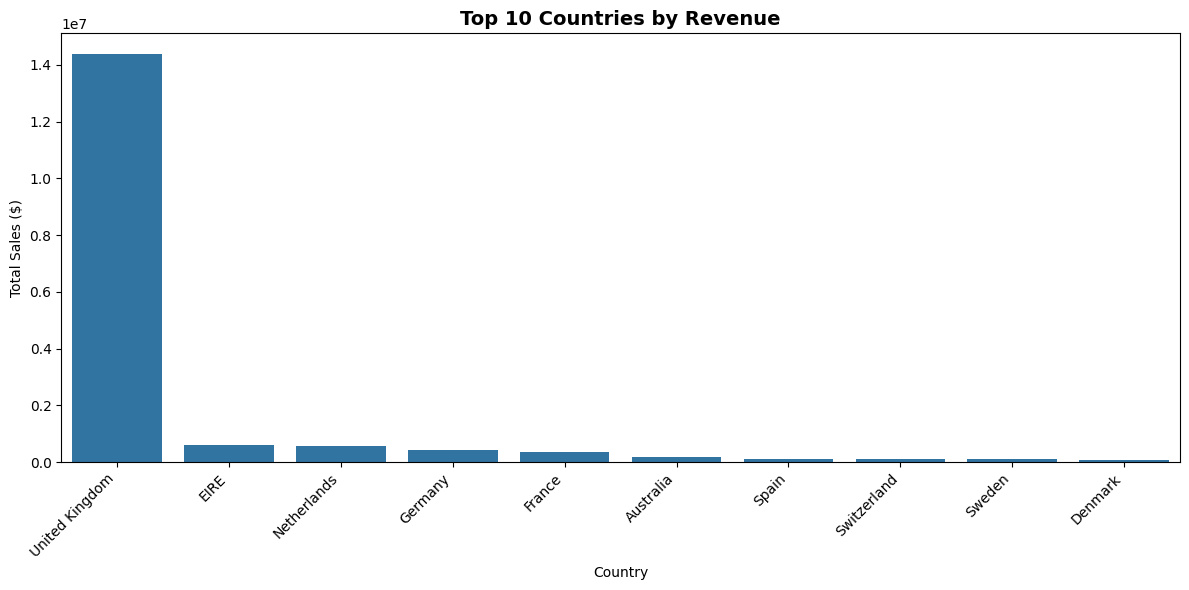

In [16]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10.index, y=top_10.values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Countries by Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Country')
plt.ylabel('Total Sales ($)')
plt.tight_layout()

The United Kingdom generates the highest revenue, which aligns with the company's domestic base. Other European countries such as Ireland, the Netherlands, Germany, and France contribute smaller but meaningful revenue, suggesting opportunities for international market expansion. 

In [17]:
# Extract hour and month
df['Hour'] = df['InvoiceDate'].dt.hour
df['Month'] = df['InvoiceDate'].dt.month
df['Month_Name'] = df['InvoiceDate'].dt.month_name()

In [18]:
# --- PEAK HOURS ---
hourly_sales = df.groupby('Hour')['Sales'].sum().sort_values(ascending=False)

In [19]:
print("=== PEAK HOURS ===")
print("Top 5 Peak Hours:")
print(hourly_sales.head())

=== PEAK HOURS ===
Top 5 Peak Hours:
Hour
12    2690583.50
13    2347078.71
10    2320711.44
11    2235870.39
14    1962016.16
Name: Sales, dtype: float64


In [20]:
peak_hour = hourly_sales.idxmax()
print(f"Peak Hour: {peak_hour}:00 with total sales of ${hourly_sales.max():,.2f}")

Peak Hour: 12:00 with total sales of $2,690,583.50


In [21]:
# --- PEAK MONTHS ---
monthly_sales = df.groupby('Month')['Sales'].sum().sort_values(ascending=False)

In [22]:
print("\n=== PEAK MONTHS ===")
print("Top 5 Peak Months:")
for month, sales in monthly_sales.head().items():
    month_name = df[df['Month'] == month]['Month_Name'].iloc[0]
    print(f"{month_name}: ${sales:,.2f}")


=== PEAK MONTHS ===
Top 5 Peak Months:
November: $2,322,665.63
October: $2,068,754.46
September: $1,779,704.15
December: $1,771,135.18
June: $1,296,417.18


In [23]:
peak_month = monthly_sales.idxmax()
peak_month_name = df[df['Month'] == peak_month]["Month_Name"].iloc[0]
print(f"Peak Month: {peak_month_name} with total sales of ${monthly_sales.max():,.2f}")

Peak Month: November with total sales of $2,322,665.63


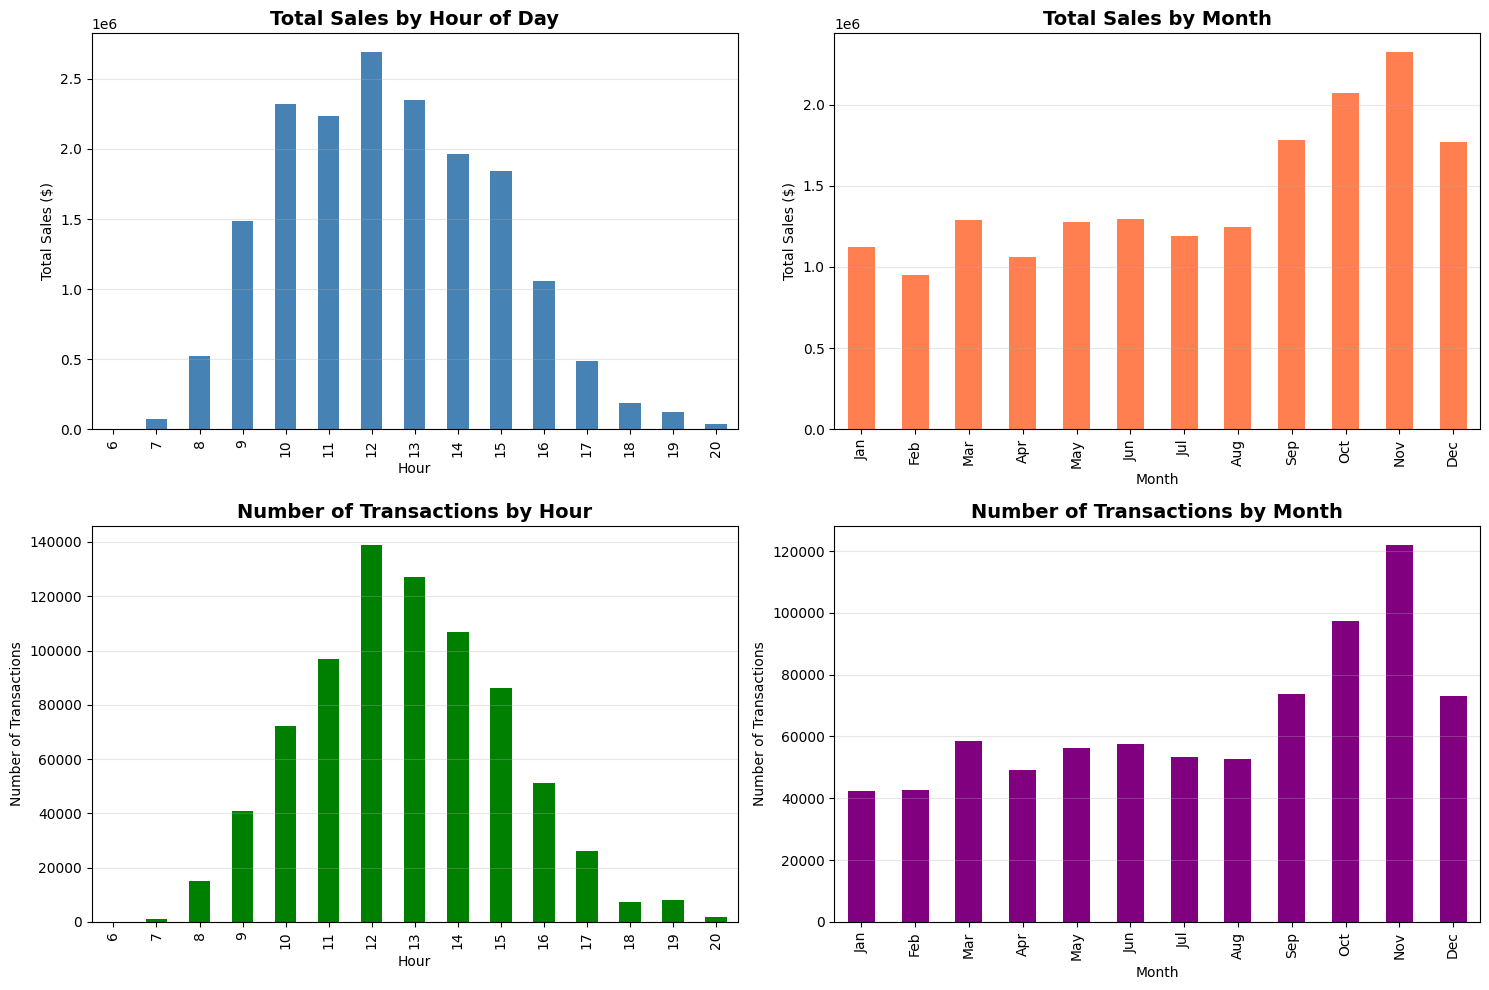

In [24]:
# --- VISUALIZATIONS ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#1. Sales by Hour 
hourly_sales.sort_index().plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Total Sales by Hour of Day', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Total Sales ($)')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Sales by Month
monthly_sales.sort_index().plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Total Sales by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Total Sales ($)')
axes[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(monthly_sales)])
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Transaction Count by Hour
hourly_transactions = df.groupby('Hour').size()
hourly_transactions.sort_index().plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_title('Number of Transactions by Hour', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Number of Transactions')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Transaction Count by Month
monthly_transactions = df.groupby('Month').size()
monthly_transactions.sort_index().plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Number of Transactions by Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(monthly_sales)])
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()

In [25]:
# Average Sales per hour
avg_hourly_sales = df.groupby('Hour')['Sales'].mean().sort_values(ascending=False)
print(
    f"Highest average transaction value by hour: "
    f"{avg_hourly_sales.idxmax()}:00 (${avg_hourly_sales.max():.2f})"
)

Highest average transaction value by hour: 7:00 ($71.93)


While the highest number of transactions and total sales occur around 12:00 (likely due to peak day time browsing and lunch-hour activity), the highest average transaction value is observed at 7:00.   
This suggests that early-morning customers - potentially wholesalers restocking or serious gift buyers planning purchases - tend to place larger orders compared to the higher-volume but smaller-basket transaction seen later in the day.   
This pattern highlights an opportunity to target premium or wholesale focused promotions as well as personalized offers, during early morning hours. 

K-Means Clustering for Customer Segmentation

In [26]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Sales', 'Hour', 'Month',
       'Month_Name'],
      dtype='object')

In [27]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [28]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique', # Frequency
    'Sales': 'sum' # Monetary
})                                   

In [29]:
rfm.head()

,InvoiceDate,Invoice,Sales
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,4921.53
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [30]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [31]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,4921.53
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [32]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled_df = pd.DataFrame(rfm_scaled,
                             index=rfm.index, columns=rfm.columns)

In [33]:
# Elbow Method 
# We test multiple k values then plot a graph

In [34]:
wcss = []

for k in range(1, 11):
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        random_state=42
    )
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

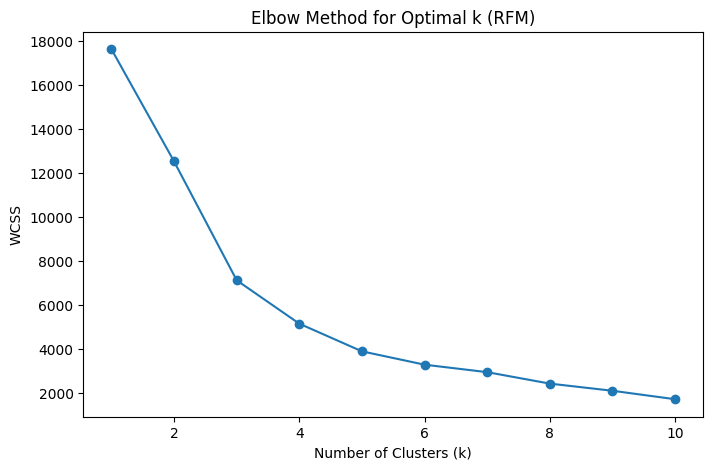

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k (RFM)')
plt.show()

In [36]:
kmeans = KMeans(n_clusters = 3,
                random_state=42)

K-Means clustering was applied after identifying an optimal cluster number using the elbow method. 

In [37]:
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [38]:
from sklearn.metrics import silhouette_score

score = silhouette_score(rfm_scaled, 
                         rfm['Cluster'])
print('Silhouette Score:', score)

Silhouette Score: 0.5827973197621373


The K-Means clustering achieved a silhouette score of 0.58, indicating reasonably well-defined customer segments with acceptable separation. This suggests the clustering structure is meaningful for business insights and targeted marketing strategies. 

In [39]:
rfm['Cluster'].nunique()

3

In [40]:
rfm.groupby('Cluster').mean()

,Recency,Frequency,Monetary
Cluster,,,
0,66.333074,7.637828,3134.790790
1,462.163682,2.202985,746.405796
2,23.090909,143.136364,173123.584091


<Axes: xlabel='Recency', ylabel='Monetary'>

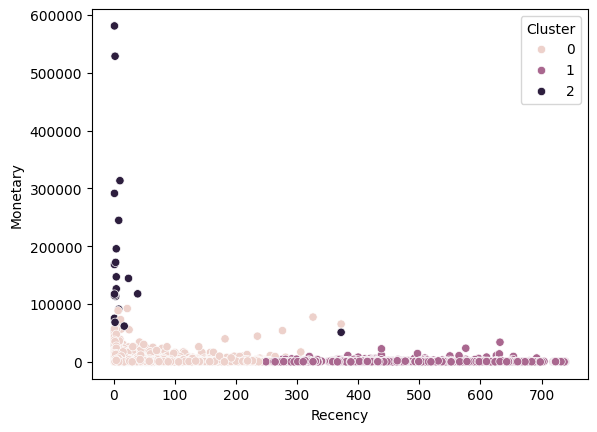

In [41]:
sns.scatterplot(x='Recency', y='Monetary',
                hue='Cluster', data=rfm)

**Cluster 2 - VIP Customers**
* Low recency (recent purchases)
* Very high monetary spending
* Represents the company's most valuable customers
These are likely VIP or loyal customers contributing significantly to revenue.   
**Business action:**
* Loyalty rewards
* Early product access
* Premium offers
* Retention strategies

**Cluster 0 - Moderate Customers**
* Relatively recent purchases
* Moderate spending levels
* Largest group in the dataset   
These are regular customers with steady but not exceptional spending    
**Business action:**
* Upselling opportunities
* Personalized offers
* Targeted promotions

**Cluster 1 - Churn-risk Customers**
* High recency (long time since last purchase)
* Low monetary value
Indicates inactive or churn-risk customers.   
**Business action:**
* Re-engagement campaigns
* Email reminders
* Discounts

**Overall Insight**  
The clustering suggests that: 
* A small group of recent customers generates disproportionately high revenue.
* Many customers make moderate purchases.
* Some customers appear inactive and may require retention efforts.   
This segmentation can help businesses tailor marketing strategies to maximize revenue and improve customer retention. 

In [42]:
# Create Label: 1 if not bought in > 90 days 
rfm['is_churned'] = (rfm['Recency'] > 90).astype(int)

Customers who have not purchased in the last 90 days are considered churned based on business assumptions. 

In [43]:
rfm.head()

,Recency,Frequency,Monetary,Cluster,is_churned
Customer ID,,,,,
12346.0,326,12,77556.46,0,1
12347.0,2,8,4921.53,0,0
12348.0,75,5,2019.40,0,0
12349.0,19,4,4428.69,0,0
12350.0,310,1,334.40,1,1


Churn Prediction Model

In [44]:
# Average Order Value
# Shows how much customers spend per transaction
rfm['Avg_Order_Value'] = rfm['Monetary']/rfm['Frequency']

In [45]:
# Customer Tenure
# Measures how long a customer has been active
first_purchase = df.groupby('Customer ID')['InvoiceDate'].min()
rfm['Tenure'] = (snapshot_date - first_purchase).dt.days

In [46]:
rfm.head()

,Recency,Frequency,Monetary,Cluster,is_churned,Avg_Order_Value,Tenure
Customer ID,,,,,,,
12346.0,326,12,77556.46,0,1,6463.038333,726
12347.0,2,8,4921.53,0,0,615.191250,404
12348.0,75,5,2019.40,0,0,403.880000,438
12349.0,19,4,4428.69,0,0,1107.172500,589
12350.0,310,1,334.40,1,1,334.400000,310


In [47]:
# --- 2. Splitting --- 
X = rfm.drop(columns=['is_churned', 'Recency'])
y = rfm['is_churned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [48]:
# SCALING 
# Fitted only on training data to prevent data leakage

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# TRAINING
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [50]:
# EVALUATION 
y_pred = model.predict(X_test_scaled)

print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))
print("\n--- Performance Metrics ---")
print(classification_report(y_test, y_pred))

--- Confusion Matrix ---
[[548  20]
 [177 432]]

--- Performance Metrics ---
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       568
           1       0.96      0.71      0.81       609

    accuracy                           0.83      1177
   macro avg       0.86      0.84      0.83      1177
weighted avg       0.86      0.83      0.83      1177



This customer churn prediction model identify "at-risk' customers before they leave, allowing business to intervene with targeted retention strategies.    
1. **The "Big Picture" Results**
   * Prediction Accuracy: 83%
   * Reliability (Precision): 96%. When the model flags a customer as "likely to churn," it is almost always correct. This prevents us from wasting marketing budget on loyal customers who don't need a discount.
   * Capture Rate (Recall): 71%. The model successfully identifies 7 out of every 10 customers who are actually planning to leave.
2. **Business Impact (The Confusion Matrix)**
   In our test of 1,177 customers, the model performed as follows:
   | Outcome | Number of Customers | What this means for the CEO |
   |:--------|:-------------------:|-----------------------------|
   | Success (Caught)| 432 | We identified these churners in time to offer a retention incentive.|
   | False Alarm | 20 | We sent a "We miss you" email to only 20 people who were going to stay anyway(Minimal waste).|
   | The Misses | 177 | These customers left without the model flagging them (Room for future improvement).|
   | Loyalists | 548 | We correctly identified these as safe, happy customers. |
3. **Strategy Recommendations**
   Based on these results, I recommend the following actions:
   * **Automated Intervention:** High-confidence flags (96% precision) should trigger an automatic loyalty reward or personalized reach-out.
   * **Low-Risk Testing:** Because the "False Alarm" rate is so low (only 1.7% of total test cases), we can be aggressive with our retention offers without fear of "cannibalizing" revenue from loyal customers.
   * **Future Growth:** To capture the 29% of churners we missed, we should incorporate more data points such as customer service interactions or product category preferences.

In [51]:
# INSIGHTS 
feature_importance = pd.DataFrame({'Feature': X.columns, 
                                   'Coef':model.coef_[0]})
print("\n-- Feature Coefficients ---")
print(feature_importance.sort_values(by='Coef', ascending=False))


-- Feature Coefficients ---
           Feature      Coef
2          Cluster  3.311480
4           Tenure  0.613926
3  Avg_Order_Value -0.098160
1         Monetary -0.581263
0        Frequency -2.197623


**Key Insights: What Drives Customer Loyalty?**   
This model identifies the specific behavioural triggers that indicate whether a customer is likely to stay or leave. By analyzing the Feature Coefficients, we can determine the "weight" and direction of each attribute's influence on churn.   
1. The Importance of Data Integrity: Avoiding Leakage   
   A critical  step in this analysis was the intentional removal of 'Recency' from the feature set. While including Recency (days since last purchase) would have resulted in nearly 100% accuracy, it would have created a "Data Leakage" scenario. Because the target variable (Churn) was defined using Recency, including it as a predictor would mean the model was simply "checking the answer" rather than learning behaviour. By removing it, the model is forced to predict churn based on actual shopping patterns.
2. Top Predictors of churn
   Based on the final model output, here is how the features impact a customer's likelihood to leave:
    * Frequency (The primary Driver): With a strong negative coefficient of -2.19, Frequency is the most important predictor.
        * Insight: Every additional unique visit significantly lowers the probability of churn. Habits are stronger than one-off high-value purchases.
    * Behavioural Clusters: The 'Cluster' feature has the highest positive coefficient at 3.311.
        * Insight: This indicates that the K-Means segments we created successfully identified "at-risk" groups. Customers in specific clusters are much more likely to churn, regardless of their individual spend.
    * Monetary Value: A negative coefficient of -0.58 shows that higher total spending correlates with higher loyalty.
        * Insight: High-value customers are generally "stickier," but this is a secondary predictor compared to how often they visit.
    * Tenure: Tenure has a positive coefficient of 0.61.
        * Insight: Tenure shows a positive relationship with churn (+0.61). However, whn interpreted alongside Frequency (-2.19), this indicates that customers who have been with us for a long time but have not increased their purchase frequency are at higher risk. Essentially, 'stale' long-term customers are more likely to churn than active new customers. 
3. Strategic Recommendations
    * Target the "Frequency Gap": Marketing efforts should prioritize increasing the number of visits rather than just the order size. Moving a customer from 2 visits to 5 visits provides a much larger boost to loyalty than moving them from a #50 order to a #100 order.
    * Cluster-Based Intervention: Our analysis identifies Cluster 1 as the primary 'At-Risk' segment. Since this group exhibits the highest probability of churn (driven by high recency and low frequency), we should design specific win-back campaigns targeting this exact segment, rather than applying a generic strategy across all customers. 
    * High Confidence Targeting: With a 96% Precision rate, the business can confidently offer aggressive discounts or expensive loyalty rewards to flagged customers, knowing that we are very unlikely to waste these offers on customers who were going to stay anyway.  